<IPython.core.display.Javascript object>


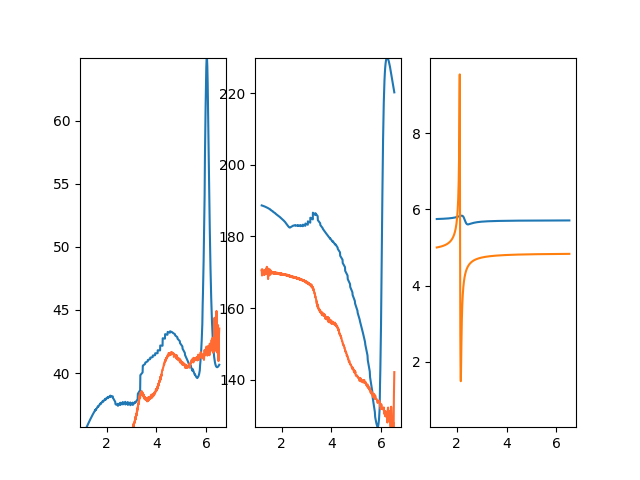

interactive(children=(FloatSlider(value=20.0, description='dx', max=20.0, min=1.0, step=1e-05), FloatSlider(va…

<function __main__.update(dx=FloatSlider(value=20.0, description='dx', max=20.0, min=1.0, step=1e-05), wp=FloatSlider(value=1.0, description='wp', max=5.0, step=1e-05), einf=FloatSlider(value=2.0, description='einf', max=40.0, step=1e-05), w0=FloatSlider(value=2.0, description='w0', max=5.0, step=1e-05), g=FloatSlider(value=0.1, description='g', max=0.5, step=1e-05))>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import tmm.tmm as tmm
import tmm.models as models
import pandas as pd
import time

data = np.loadtxt('data/ytas2/248_0_Psi,Delta_190-3500_50deg.csv',skiprows=1)
# x axis in nm 
cutoff = 220
omegas = 1240/data[0:-cutoff,0] # grid in eV
# basically all energy units in eV, al length scales in nm

ref = np.loadtxt('data/ytas2/2022_12_23_HR_Si_Psi_delta_70deg_190-3500nm.txt',skiprows=1)

si = pd.read_csv('data/ytas2/RefractiveIndexSI.csv')
tab_si_grid = si['Photon energy, eV'].to_numpy()
tab_si_n = si['n'].to_numpy()
tab_si_k= si['k'].to_numpy()

sio2dat = np.loadtxt('data/ytas2/RefractiveIndexSIO2.txt', delimiter=" ", dtype=float, encoding='utf-8-sig')
tab_sio2_grid = sio2dat[:,0]
tab_sio2_n  = sio2dat[:,1]
tab_sio2_k = np.zeros(tab_sio2_n.shape[0]) # transparent 

def grid_adapt(omegas,tab_grid,tab_n,tab_k):
### adapt tabulated model params to measured energy grid
    si_ad = np.zeros(omegas.shape[0],dtype=complex)
    for i in np.arange(omegas.shape[0]):
        en = omegas[i]
        # find energy value in a table closest to measured value
        ind = (np.abs(tab_grid - en)).argmin()
        # fill this value in grid with complex refractive index
        si_ad[i] = tab_n[ind]+1.j*tab_k[ind]
    
    return si_ad

si_ad = grid_adapt(omegas, tab_si_grid, tab_si_n, tab_si_k)
sio2_ad = grid_adapt(omegas, tab_sio2_grid, tab_sio2_n, tab_sio2_k)

phi = 50
lambd = 1240/omegas

psi = np.zeros(omegas.shape[0],dtype=np.float64)
delta = np.zeros(omegas.shape[0],dtype=np.float64)

%matplotlib notebook
import ipywidgets as wg

dx=100
einf=2
wp=1
w0=2
g=0.1

d_min = 1
d_max = 20
d_fit = np.array([0],dtype=float)

einf_min = 0
einf_max = 40
einf_fit = np.array([0],dtype=float)

wp_min = 0
wp_max = 5
wp_fit = np.array([0],dtype=float)

w0_min = 0
w0_max = 5
w0_fit = np.array([0],dtype=float)

g_min = 0
g_max = 0.5
g_fit = np.array([0],dtype=float)

dx_slide = wg.FloatSlider(min=d_min,max=d_max,step= .00001,value=dx)
wp_slide = wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value=wp)
einf_slide = wg.FloatSlider(min=einf_min,max=einf_max,step= .00001,value=einf)
w0_slide = wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value=w0)
g_slide = wg.FloatSlider(min=g_min,max=g_max,step= .00001,value=g)

dox=5.5 # fitted substrate
A=1.45
B=3500 # in units nm**2

nair = np.ones(omegas.shape[0])
nox = models.Cauchy(A,B,lambd)
nsi = si_ad
nx = models.DrudeLorentz(einf,wp,w0,g,omegas)

n = np.array([nair,nx,nox,nsi]) # nsi here will be from table, nox will be fitted with cauchy

fig, ax =  plt.subplots(1,3)

line_psi, = ax[0].plot(omegas, psi)
line_delta, = ax[1].plot(omegas, delta)

line_psi_data = ax[0].plot(omegas,data[:-cutoff,1],c='#FF6B33')
line_delta_data = ax[1].plot(omegas,data[:-cutoff,2],c='#FF6B33')

line_refr_nt, = ax[2].plot(omegas,nx)
nx_paper = models.DrudeLorentz(23.48,2.1721,2.1253,0.02,omegas)
line_refr_nt_paper = ax[2].plot(omegas, nx_paper) 

def corr_delta(delt):
    # eliminates 2pi steps in delta
    if np.size(np.where(np.diff(delt)>100)[0])>0:
        crr_delta = np.zeros(omegas.shape[0],dtype=np.float64)
        for i in range(delt.shape[0]):
            crr_delta[i] = delt[i]
        for i in np.where(np.diff(delt)>100)[0]:
            for j in range(int(i)+1,omegas.shape[0],1):
                crr_delta[j] = delt[j]-360*(2*int(np.diff(delt)[i]>0)-1)
        return corr_delta(crr_delta)
    else:        
        return delt

def update(dx=dx_slide,wp=wp_slide,einf=einf_slide,w0=w0_slide,g=g_slide):
    startTime = time.time()
    nx = models.DrudeLorentz(einf,wp,w0,g,omegas)
    n = np.array([nair,nx,nox,nsi])
    d = np.array([0,dx,dox,0])
    for ind in range(omegas.shape[0]):
        psi[ind] = tmm.solve_psi(n[:,ind],d,phi,lambd[ind])
        delta[ind] = tmm.solve_delta(n[:,ind],d,phi,lambd[ind])
    #delt = corr_delta(delta)
    delt=delta
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))
    
    line_psi.set_ydata(psi)
    line_delta.set_ydata(delt)
    line_refr_nt.set_ydata(nx)
    
    ax[0].set_ylim([np.min(psi), np.max(psi)])
    ax[1].set_ylim([np.min(delt), np.max(delt)])
    
    fig.canvas.draw_idle()
    
    d_fit[0] = dx
    wp_fit[0] = wp
    einf_fit[0] = einf
    w0_fit[0] = w0
    g_fit[0] = g

    
wg.interact(update)

In [21]:
plt.close()

<ipython-input-21-60fa62c0aada>:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()
